# Logistic regression 스팸 필터링

# 하이퍼파라미터
사용자가 학습 알고리즘에 설정해주는 변수입니다. 예를 들어 스팸 필터링에는 정규화 값, 빈도에 따라 제거할 단어의 빈도 임계치등을 있습니다. `sklearn`에 제공하는 기본 값을 사용하는 것도 나쁘지 않으나 최적의 모델을 만들기 위해서는 하이퍼파라미터의 튜닝이 필요합니다.

# Grid search
그리드 탐색은 최적 모델 생성을 위해 흔히 사용되는 기법입니다. 튜닝해야 하는 각각의 하이퍼파라미터들의 집합을 가지고 모델을 훈련합니다. 경우의 수가 많기 때문에 그리드 탐색은 계산량이 많다는 단점이 있습니다. 

# 사용할 데이터

In [1]:
import pandas as pd
df = pd.read_csv('./data/SMSSpamCollection.txt', delimiter='\t', header = None)
df.tail()

0                                                  1
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

총 5571개의 데이터가 들어있군요. 각각이 **ham, spam**으로 분류가 되어 있습니다. **ham**의 갯수만 세어 보겠습니다.

In [2]:
df[df[0] == 'ham'][0].count()

4825

In [3]:
df[df[0] == 'spam'][0].count()

747

스팸이 8분의 1정도로 전체 데이터셋은 균일하지 않습니다. 이것은 모델 평가 지표를 선택할 때 고려해야 할 사항입니다. 

In [4]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

X = df[1].values
y = df[0].values
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X,y, test_size =0.3, random_state=42) 

In [5]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.fit_transform(X_test_raw)

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)

score = cross_val_score(log_clf, X_train, y_train, cv=5)
print('Accuracy: {}'.format(np.mean(score)))


Accuracy: 0.9494825140266208


# 혼동 행렬 그리기

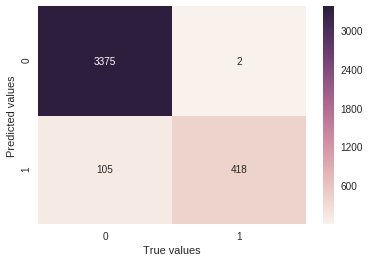

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = log_clf.predict(X_train)
cf_matrix = confusion_matrix(y_train, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt="d").set(xlabel='True values', ylabel='Predicted values')

혼동 행렬을 보면 

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])

In [9]:
parameters = {
    'vect__max_df' : (0.25, 0.5, 0.75),
    'vect__stop_words' : ('english', None),
    'vect__max_features': (2500,5000,10000,None),
    'vect__ngram_range':((1, 1), (1,2)),
    'vect__use_idf': (True,False),
    'vect__norm': ('l1','l2'),
    'clf__penalty':('l1','l2'),
    'clf__C': (0.01,0.1,1,10),
}

X = df[1].values

label_encoder = LabelEncoder()
y= label_encoder.fit_transform(df[0].values)

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [10]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='recall', cv=10) #n_jobs = 사용할 cpu 코어의 수
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 1536 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 12736 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 14386 tasks      | elapsed: 

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'vect__max_df': (0.25, 0.5, 0.75), 'vect__stop_words': ('english', None), 'vect__max_features': (2500, 5000, 10000, None), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'vect__norm': ('l1', 'l2'), 'clf__penalty': ('l1', 'l2'), 'clf__C': (0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='recall', verbose=1)

In [11]:
grid_search.best_score_

0.91803455962727831

In [12]:
best_param = grid_search.best_estimator_.get_params()
for i in sorted(parameters.keys()):
    print('{} : {} '.format(i, best_param[i]))

clf__C : 10 
clf__penalty : l1 
vect__max_df : 0.5 
vect__max_features : None 
vect__ngram_range : (1, 2) 
vect__norm : l2 
vect__stop_words : None 
vect__use_idf : True 


In [13]:
y_pred = grid_search.predict(X_test)
print('Accuracy : ',accuracy_score(y_test, y_pred))
print('Precision_score : ',precision_score(y_test, y_pred))
print('Recall_score : ',recall_score(y_test, y_pred))

Accuracy :  0.981335247667
Precision_score :  0.93023255814
Recall_score :  0.919540229885
